In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import numpy as np
import torch
import cPickle as cp
import sys, os
sys.path.append("../../utils")
sys.path.append("../")

from data_loader import load_census_data, load_census_data_part
from plot_utils import get_colors
import rff
from rff import GaussianKernel, RFF
from kernel_regressor import Quantizer, KernelRidgeRegression
from bit_assignment import binary_search_bits_assignment
from pca_rff import PCA_RFF

In [2]:
colors_dict = get_colors()

In [3]:
class Args(object):
    def __init__(self, n_fp_rff, n_bit, 
                 exact_kernel, reg_lambda, 
                 sigma, random_seed, data_path,
                 do_fp, test_var_reduce=False):
        self.n_fp_rff = n_fp_rff
        self.n_bit = n_bit
        self.exact_kernel = exact_kernel
        self.reg_lambda = reg_lambda
        self.sigma = sigma
        self.random_seed = random_seed
        self.data_path = data_path
        self.do_fp = do_fp
        self.test_var_reduce = test_var_reduce

In [4]:
def load_census_data(path):
    X_test = np.load(path + "X_ho.npy")
    X_train = np.load(path + "X_tr.npy")
    Y_test = np.load(path + "Y_ho.npy")
    Y_train = np.load(path + "Y_tr.npy")
    X_test = X_test.item()['X_ho']
    X_train = X_train.item()['X_tr']
    Y_test = Y_test.item()['Y_ho']
    Y_train = Y_train.item()['Y_tr']
    s = np.arange(X_train.shape[0] )
    np.random.seed(0)
    np.random.shuffle(s)
    X_train = X_train[s, :]
    Y_train = Y_train[s]
    X_train, Y_train, X_test, Y_test = \
      X_train[:(s.size * 1 / 5), :], Y_train[:(s.size * 1 / 5)], X_test[:(s.size * 1 / 5), :], Y_test[:(s.size * 2 / 3)]
    return X_train, X_test, Y_train, Y_test

In [5]:
data_path = "../../../data/census/"

### preliminary test with 1024 fp feat memory

In [6]:
X_train, X_test, Y_train, Y_test = load_census_data(data_path)

n_input_feat = X_train.shape[1]
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=True, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)

# get exact kernel
kernel = GaussianKernel(sigma=args.sigma)
kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)

results = {}

# get a full precision rff kernel
kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
kernel_mat_fp_rff = kernel.get_kernel_matrix(X_train, X_train)
results["fp_rff_error"] = (torch.sum( (kernel_mat_fp_rff - kernel_mat_exact_train)**2), \
    torch.sum( (kernel_mat_fp_rff - kernel_mat_fp_rff)**2) )
print "fp rff error ", results["fp_rff_error"]
    
# get a full precision PCA RFF
kernel = GaussianKernel(sigma=args.sigma)
kernel = PCA_RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed, mu=1.0)
kernel.setup(X_train, n_fp_feat_budget=args.n_fp_rff)
# kernel_mat_fp_pca_rff = kernel.get_kernel_matrix(X_train, X_train)
regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
regressor.fit(X_train, Y_train)
kernel_mat_fp_pca_rff = regressor.kernel_mat
train_error = regressor.get_train_error()
regressor.kernel.test_mode()
pred = regressor.predict(X_test)
test_error = regressor.get_test_error(Y_test)
results["fp_pca_rff_error"] = (torch.sum( (kernel_mat_fp_pca_rff - kernel_mat_exact_train)**2), \
    torch.sum( (kernel_mat_fp_pca_rff - kernel_mat_fp_rff)**2), train_error, test_error)
print "fp pca rff error ", results["fp_pca_rff_error"]

for n_fp_feat_budget in [1024, 512, 256, 128, 64, 32]: 
    
    print
    print
    print
    print "fp feat budget ", n_fp_feat_budget
    
    for seed in range(1, 2):
        for nbit in [4, 2, 1]:
            kernel = GaussianKernel(sigma=args.sigma)
            n_quantized_rff = int(np.floor(n_fp_feat_budget / float(nbit) * 32.0) )
            min_val = -np.sqrt(2.0/float(n_quantized_rff) )
            max_val = np.sqrt(2.0/float(n_quantized_rff) )
            kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=seed)
            quantizer = Quantizer(nbit, min_val, max_val, rand_seed=seed)
            regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
            regressor.fit(X_train, Y_train, quantizer=quantizer)
            kernel_mat_lp_rff = regressor.kernel_mat
            train_error = regressor.get_train_error()
            pred = regressor.predict(X_test, quantizer_train=quantizer, quantizer_test=quantizer)
            test_error = regressor.get_test_error(Y_test)
#             kernel_mat_lp_rff = kernel.get_kernel_matrix(X_train, X_train, quantizer1=quantizer, quantizer2=quantizer)
            assert "lp_rff_budget_" + str(n_fp_feat_budget) + "_nbit_" + str(nbit) not in results.keys()
            results["lp_rff_budget_" + str(n_fp_feat_budget) + "_nbit_" + str(nbit) ] \
                = (torch.sum( (kernel_mat_lp_rff - kernel_mat_exact_train)**2), \
                torch.sum( (kernel_mat_lp_rff - kernel_mat_fp_rff)**2), train_error, test_error)
            print "lp rff budget ", n_fp_feat_budget, "nbit", nbit, "seed", seed, results["lp_rff_budget_" + str(n_fp_feat_budget) + "_nbit_" + str(nbit) ]

        for mu in [1.0, 2.0, 3.0, 5.0, 10.0, 0.2, 0.33, 0.5]:
            # get a low precision PCA RFF
            kernel = GaussianKernel(sigma=args.sigma)
            kernel = PCA_RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=seed, mu=mu)
            kernel.setup(X_train, n_fp_feat_budget=n_fp_feat_budget)
#             kernel_mat_lp_pca_rff = kernel.get_kernel_matrix(X_train, X_train, quantizer1=Quantizer, quantizer2=Quantizer)
            regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
            regressor.fit(X_train, Y_train, quantizer=Quantizer)
            kernel_mat_lp_pca_rff = regressor.kernel_mat
            train_error = regressor.get_train_error()
            regressor.kernel.test_mode()
            pred = regressor.predict(X_test, quantizer_train=Quantizer, quantizer_test=Quantizer)
            test_error = regressor.get_test_error(Y_test)
            assert "lp_pca_rff_budget_" + str(n_fp_feat_budget) + "_mu_" + str(kernel.mu) not in results.keys()
            results["lp_pca_rff_budget_" + str(n_fp_feat_budget) + "_mu_" + str(kernel.mu) ] \
                = (torch.sum( (kernel_mat_lp_pca_rff - kernel_mat_exact_train)**2), \
                torch.sum( (kernel_mat_lp_pca_rff - kernel_mat_fp_rff)**2), train_error, test_error)
            print "lp pca rff budget ", n_fp_feat_budget, "mu", kernel.mu, "seed", seed, results["lp_pca_rff_budget_" + str(n_fp_feat_budget) + "_mu_" + str(kernel.mu) ]
            print kernel.bit_assignment[:100]
            print kernel.bit_assignment[-100:-1]

# # # test 1 
# print np.mean(np.abs(kernel_mat_fp_rff.cpu().numpy()- kernel_mat_fp_pca_rff.cpu().numpy() ) )
# np.testing.assert_array_almost_equal(kernel_mat_fp_rff.cpu().numpy(), kernel_mat_fp_pca_rff.cpu().numpy(), decimal=6)
# # # print kernel_mat_fp_rff
# # # print kernel_mat_fp_pca_rff
# # # print kernel.offset
# # # print kernel.S

fp rff error  (1984.113996131371, 0.0)
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
('using regularior strength ', 0.001)
fp pca rff error  (1984.1139961315334, 1.460623354084373e-23, 7773378.892452846, 56066176.98180907)



fp feat budget  1024
('using regularior strength ', 0.001)
lp rff budget  1024 nbit 4 seed 1 (408.26965695243365, 3002.850939162163, 612785.870217943, 47960493.04416257)
('using regularior strength ', 0.001)
lp rff budget  1024 nbit 2 seed 1 (307.00736912357024, 1903.209023483564, 5175.217185573909, 74809365.62982689)
('using regularior strength ', 0.001)
lp rff budget  1024 nbit 1 seed 1 (4218.982914966296, 6041.872574459801, 199.93301489329815, 175111448.32301447)
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
('using regularior strength ', 0.001)
lp pca rff budget  1024 mu 1.0 seed 1 (43706.15246244954, 413

lp rff budget  512 nbit 1 seed 1 (5121.838553250419, 6738.274000868616, 359.96750426194376, 207071456.74877283)
('found exact assignment plan', array([16, 16, 16, ..., 16, 16, 16]))
('best solution, memory budget ', 512.0, ' / ', 512)
('using regularior strength ', 0.001)
lp pca rff budget  512 mu 1.0 seed 1 (43706.12482220431, 41336.17033650327, 218067614.52370092, 421615150.99833)
[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16]
[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16]
('found

('found exact assignment plan', array([16, 16, 16, ...,  4,  4,  4]))
('best solution, memory budget ', 256.0, ' / ', 256)
('using regularior strength ', 0.001)
lp pca rff budget  256 mu 2.0 seed 1 (14639.882037156665, 12603.981626552077, 31462709.59623386, 143046841.46645784)
[16 16 16 16 16 16 16 16 16 16 16 16  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8]
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
('found exact assignment plan', array([16, 16, 16, ...,  4,  4,  4]))
('best solution, memory budget ', 256.0, ' / ', 256)
('using regularior strength ', 0.001)
lp pca rff budget  256 mu 3.0 seed 1 (5811.38741604099

('best solution, memory budget ', 127.9375, ' / ', 128)
('using regularior strength ', 0.001)
lp pca rff budget  128 mu 10.0 seed 1 (2060.865884112541, 113.6243081590455, 12199500.998696208, 62367206.355419956)
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
('best solution, memory budget ', 127.9375, ' / ', 128)
('using regularior strength ', 0.001)
lp pca rff budget  128 mu 0.2 seed 1 (89778.82051496043, 91482.30712824222, 1459596789.0340917, 1547587026.628415)
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8

('found exact assignment plan', array([8, 8, 4, ..., 0, 0, 0]))
('best solution, memory budget ', 32.0, ' / ', 32)
('using regularior strength ', 0.001)
lp pca rff budget  32 mu 1.0 seed 1 (43740.999801592705, 41345.31992361812, 285113591.9877165, 445063396.46034855)
[8 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('found exact assignment plan', array([8, 8, 4, ..., 0, 0, 0]))
('best solution, memory budget ', 32.0, ' / ', 32)
('using regularior strength ', 0.001)
lp pca rff budget  32 mu 2.0 seed 1 (15080.878114084822, 13042.724854111788, 80838287.91166483, 180850178.0226584)
[8 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

In [7]:
import cPickle as cp
with open("./results_rff_pca_with_l2.pkl", "w") as f:
    cp.dump(results, f)

In [ ]:
print kernel.bit_assignment[:1000]
print kernel.bit_assignment[-1000:-1]
print np.sum(kernel.bit_assignment) / float(32)

In [ ]:
def get_spectrum(args):
    X_train, X_test, Y_train, Y_test = load_census_data(args.data_path)
    kernel = GaussianKernel(sigma=args.sigma)
    kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)
    kernel_mat_exact_test = kernel.get_kernel_matrix(X_test, X_train)
    n_input_feat = X_train.shape[1]
    assert X_train.shape[1] == X_test.shape[1]
    if args.exact_kernel:
        print "exact kernel"
        kernel = kernel
        quantizer_train = None
        quantizer_test = None
        config_name = "exact_kernel_lambda_" + str(args.reg_lambda) + "_sigma_" + str(args.sigma)
    elif args.do_fp:
        print "full precision rff"
        kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        quantizer_train = None
        quantizer_test = None
        config_name = "fp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff)
    else:
        print "low precsion rff with nbit = ", args.n_bit
        n_quantized_rff = int(np.floor(args.n_fp_rff / float(args.n_bit) * 32.0) )
        min_val = -np.sqrt(2.0/float(n_quantized_rff) )
        max_val = np.sqrt(2.0/float(n_quantized_rff) )
        quantizer_train = Quantizer(args.n_bit, min_val, max_val, rand_seed=args.random_seed)
        if not args.test_var_reduce:
            quantizer_test = quantizer_train
        else:
            quantizer_test = None
        kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        config_name = "lp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff) + "_nbit_" + str(args.n_bit) 

    regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
    print("start to do regression!")
    # print("test quantizer", quantizer)
    regressor.fit(X_train, Y_train, quantizer=quantizer_train)
    print("finish regression!")
    
    kernel_mat = regressor.kernel_mat
    _, s, _ = np.linalg.svd(kernel_mat.cpu().numpy().astype(np.float64), full_matrices=True)
    return s

In [72]:
def get_spectrum(args):
    X_train, X_test, Y_train, Y_test = load_census_data(args.data_path)
    kernel = GaussianKernel(sigma=args.sigma)
    kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)
    kernel_mat_exact_test = kernel.get_kernel_matrix(X_test, X_train)
    n_input_feat = X_train.shape[1]
    assert X_train.shape[1] == X_test.shape[1]
    if args.exact_kernel:
        print "exact kernel"
        kernel = kernel
        quantizer_train = None
        quantizer_test = None
        config_name = "exact_kernel_lambda_" + str(args.reg_lambda) + "_sigma_" + str(args.sigma)
    elif args.do_fp:
        print "full precision rff"
        kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        quantizer_train = None
        quantizer_test = None
        config_name = "fp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff)
    else:
        print "low precsion rff with nbit = ", args.n_bit
        n_quantized_rff = int(np.floor(args.n_fp_rff / float(args.n_bit) * 32.0) )
        min_val = -np.sqrt(2.0/float(n_quantized_rff) )
        max_val = np.sqrt(2.0/float(n_quantized_rff) )
        quantizer_train = Quantizer(args.n_bit, min_val, max_val, rand_seed=args.random_seed)
        if not args.test_var_reduce:
            quantizer_test = quantizer_train
        else:
            quantizer_test = None
        kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        config_name = "lp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff) + "_nbit_" + str(args.n_bit) 

    regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
    print("start to do regression!")
    # print("test quantizer", quantizer)
    regressor.fit(X_train, Y_train, quantizer=quantizer_train)
    print("finish regression!")
    
    kernel_mat = regressor.kernel_mat
    _, s, _ = np.linalg.svd(kernel_mat.cpu().numpy().astype(np.float64), full_matrices=True)
    return s

### exact kernel

In [73]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=True, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_exact = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_exact)
# print s_exact

KeyboardInterrupt: 

### 1024 feature full precision

In [12]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=True)
s_fp = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd.npy", "wb") as f:
    np.save(f, s_fp)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd.npy", "rb") as f:
    test = np.load(f)
print np.sum(s_fp - test)

('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 1024)
start to do regression!
('using regularior strength ', 0.001)
finish regression!
0.0


### 1024 feature 8 --> 1 bit

In [8]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_8 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_8)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  8
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 4096)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 8)
('quantizer 1 scale', 0.00017331048558493812)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 8)
('quantizer 2 scale', 0.00017331048558493812)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [7]:
args = Args(n_fp_rff=1024, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_4 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_4)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0020833333333333333)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0020833333333333333)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [6]:
args = Args(n_fp_rff=1024, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_2 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_2)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [25]:
args = Args(n_fp_rff=1024, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!
('quantization 1 activated ', (10911, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.015625)
('quantizer using random seed', 1)


KeyboardInterrupt: 

In [7]:
args = Args(n_fp_rff=1024, n_bit=16, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_16 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_16)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  16
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 2048)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 16)
('quantizer 1 scale', 9.5368886854352636e-07)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 16)
('quantizer 2 scale', 9.5368886854352636e-07)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [8]:
args = Args(n_fp_rff=1024, n_bit=32, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_32 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd.npy", "wb") as f:
    np.save(f, s_32)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  32
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 1024)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 32)
('quantizer 1 scale', 2.0579515879251518e-11)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 32)
('quantizer 2 scale', 2.0579515879251518e-11)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [6]:
args = Args(n_fp_rff=2048, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_2048_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0014731391274719742)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0014731391274719742)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [7]:
args = Args(n_fp_rff=2048, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_2048_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.005208333333333333)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.005208333333333333)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [8]:
args = Args(n_fp_rff=2048, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_2048_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 65536)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.011048543456039806)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.011048543456039806)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [9]:
args = Args(n_fp_rff=4096, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_4096_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0010416666666666667)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0010416666666666667)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [10]:
args = Args(n_fp_rff=4096, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_4096_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 65536)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0036828478186799354)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0036828478186799354)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [11]:
args = Args(n_fp_rff=4096, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_4096_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 131072)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.0078125)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.0078125)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [17]:
args = Args(n_fp_rff=8192, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_8192_feat_4_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 65536)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.00073656956373598711)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.00073656956373598711)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [18]:
args = Args(n_fp_rff=8192, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_8192_feat_2_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 131072)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0026041666666666665)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0026041666666666665)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


In [19]:
args = Args(n_fp_rff=8192, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_8192_feat_1_bit_64b_svd_full_dataset.npy", "wb") as f:
    np.save(f, s_1)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 262144)
start to do regression!
('quantization 1 activated ', (16367, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.0055242717280199029)
('quantizer using random seed', 1)
('quantization 2 activated ', (16367, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.0055242717280199029)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!


### Plot results

In [22]:
# with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "rb") as f:
#     s_4_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd.npy", "rb") as f:
#     s_2_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_exact_64b_svd.npy", "rb") as f:
#     s_exact_small = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_32 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_16 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd_full_dataset.npy", "rb") as f:
    s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)

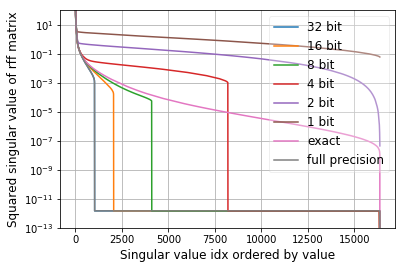

In [23]:
plt.figure()
plt.semilogy(s_32, label="32 bit")
plt.semilogy(s_16, label="16 bit")
plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit")
plt.semilogy(s_2, label="2 bit")
plt.semilogy(s_1, label="1 bit")
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="full precision")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
# plt.semilogy(s_exact_small, label="exact partial")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Squared singular value of rff matrix", fontsize=12)
plt.xlabel("Singular value idx ordered by value", fontsize=12)
plt.savefig("../../notes/figures/spectrum_1024.pdf")
plt.show()

In [24]:
# with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "rb") as f:
#     s_4_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd.npy", "rb") as f:
#     s_2_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_exact_64b_svd.npy", "rb") as f:
#     s_exact_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_8192_feat_32_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_32 = np.load(f)
# with open("../multi_seed_results/spectrum/s_8192_feat_16_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_16 = np.load(f)
# with open("../multi_seed_results/spectrum/s_8192_feat_8_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)

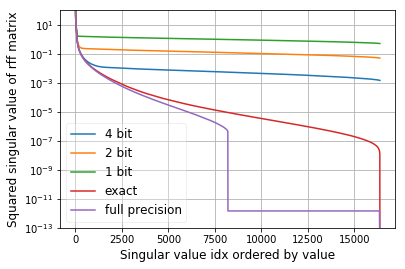

In [25]:
plt.figure()
# plt.semilogy(s_32, label="32 bit")
# plt.semilogy(s_16, label="16 bit")
# plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit")
plt.semilogy(s_2, label="2 bit")
plt.semilogy(s_1, label="1 bit")
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="full precision")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
# plt.semilogy(s_exact_small, label="exact partial")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Squared singular value of rff matrix", fontsize=12)
plt.xlabel("Singular value idx ordered by value", fontsize=12)
plt.savefig("../../notes/figures/spectrum_8192.pdf")
plt.show()

### same number of features

In [26]:
# with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "rb") as f:
#     s_4_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd.npy", "rb") as f:
#     s_2_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_exact_64b_svd.npy", "rb") as f:
#     s_exact_small = np.load(f)
# with open("../multi_seed_results/spectrum/s_8192_feat_32_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_32 = np.load(f)
# with open("../multi_seed_results/spectrum/s_8192_feat_16_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_16 = np.load(f)
# with open("../multi_seed_results/spectrum/s_8192_feat_8_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_4096_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_2048_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)

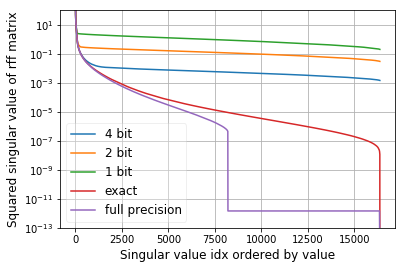

In [27]:
plt.figure()
# plt.semilogy(s_32, label="32 bit")
# plt.semilogy(s_16, label="16 bit")
# plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit")
plt.semilogy(s_2, label="2 bit")
plt.semilogy(s_1, label="1 bit")
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="full precision")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
# plt.semilogy(s_exact_small, label="exact partial")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Squared singular value of rff matrix", fontsize=12)
plt.xlabel("Singular value idx ordered by value", fontsize=12)
# plt.savefig("../../notes/figures/spectrum_8192.pdf")
plt.show()

### plot spectrum with similar kernel approximation error

In [74]:
with open("../multi_seed_results/spectrum/s_4096_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_4096_feat_1_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_1_ind = np.load(f)
with open("../multi_seed_results/spectrum/s_4096_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_fp_upper = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_fp_lower = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)

In [ ]:
with open("../multi_seed_results/spectrum/k_4096_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    k_1 = np.load(f)
with open("../multi_seed_results/spectrum/k_4096_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
    k_fp_upper = np.load(f)
with open("../multi_seed_results/spectrum/k_8192_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
    k_fp_lower = np.load(f)
with open("../multi_seed_results/spectrum/k_exact_64b_svd_full_dataset.npy", "rb") as f:
    k_exact = np.load(f)

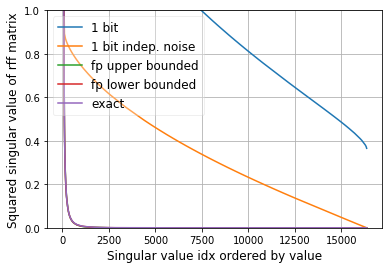

In [66]:
plt.figure()
plt.plot(s_1, label="1 bit")
plt.plot(s_1_ind, label="1 bit indep. noise")
plt.plot(s_fp_upper, label="fp upper bounded")
plt.plot(s_fp_lower, label="fp lower bounded")
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
plt.plot(s_exact, label="exact")
plt.grid()
plt.ylim([1e-13, 1])
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Squared singular value of rff matrix", fontsize=12)
plt.xlabel("Singular value idx ordered by value", fontsize=12)
plt.savefig("../../notes/figures/different_spectrum_with_same_kernel_approx_error.pdf")
plt.show()

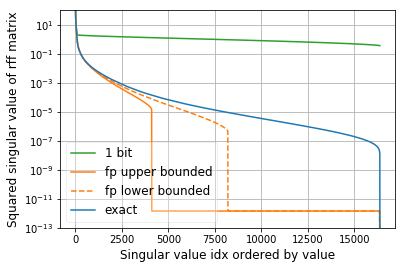

In [76]:
plt.figure()
plt.semilogy(s_1, label="1 bit", color=colors_dict['1'])
# plt.semilogy(s_1_ind, label="1 bit indep. noise")
plt.semilogy(s_fp_upper, label="fp upper bounded", color=colors_dict['fp'])
plt.semilogy(s_fp_lower, "--", label="fp lower bounded", color=colors_dict['fp'])
# plt.semilogy(s_4_small, label="4 bit partial")
# plt.semilogy(s_2_small, label="2 bit partial")
plt.semilogy(s_exact, label="exact", color=colors_dict['exact'])
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Squared singular value of rff matrix", fontsize=12)
plt.xlabel("Singular value idx ordered by value", fontsize=12)
plt.savefig("../../notes/figures/different_spectrum_with_same_kernel_approx_error_log.pdf")
plt.show()

### plot spectrum using the same number of RFF (8192 features)

In [77]:
with open("../multi_seed_results/spectrum/s_256_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_512_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_2048_feat_8_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_4096_feat_16_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_16 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_32_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_32 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)

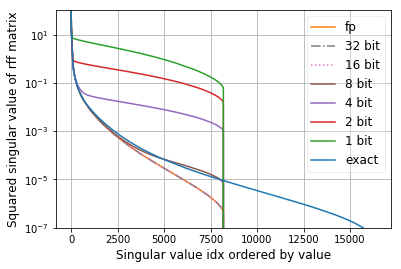

In [78]:
plt.figure()
plt.semilogy(s_fp, label="fp", color=colors_dict['fp'])
plt.semilogy(s_32, "-.", label="32 bit", color=colors_dict['32'])
plt.semilogy(s_16, ":", label="16 bit", color=colors_dict['16'])
plt.semilogy(s_8, label="8 bit", color=colors_dict['8'])
plt.semilogy(s_4, label="4 bit", color=colors_dict['4'])
plt.semilogy(s_2, label="2 bit", color=colors_dict['2'])
plt.semilogy(s_1, label="1 bit", color=colors_dict['1'])
plt.semilogy(s_exact, label="exact", color=colors_dict['exact'])
plt.grid()
plt.ylim([1e-7, 1e2])
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Squared singular value of rff matrix", fontsize=12)
plt.xlabel("Singular value idx ordered by value", fontsize=12)
plt.savefig("../../notes/figures/spectrum_n_rff_8192.pdf")
plt.show()

In [33]:
# with open("../multi_seed_results/spectrum/s_4096_feat_1_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_1 = np.load(f)
# with open("../multi_seed_results/spectrum/s_4096_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_fp_upper = np.load(f)
# with open("../multi_seed_results/spectrum/s_8192_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_fp_lower = np.load(f)
# with open("../multi_seed_results/spectrum/s_exact_64b_svd_full_dataset.npy", "rb") as f:
#     s_exact = np.load(f)

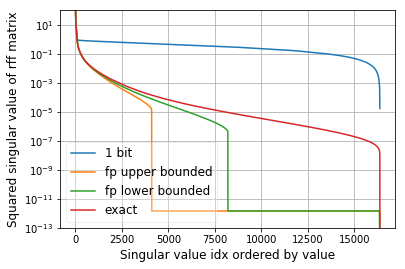

In [34]:
# plt.figure()
# plt.semilogy(s_1, label="1 bit")
# plt.semilogy(s_fp_upper, label="fp upper bounded")
# plt.semilogy(s_fp_lower, label="fp lower bounded")
# # plt.semilogy(s_4_small, label="4 bit partial")
# # plt.semilogy(s_2_small, label="2 bit partial")
# plt.semilogy(s_exact, label="exact")
# plt.grid()
# plt.ylim([1e-13, 1e2])
# plt.legend(framealpha=0.3, fontsize=12)
# plt.ylabel("Squared singular value of rff matrix", fontsize=12)
# plt.xlabel("Singular value idx ordered by value", fontsize=12)
# plt.savefig("../../notes/figures/different_spectrum_with_same_kernel_approx_error_ind_rand.pdf")
# plt.show()

# old code below

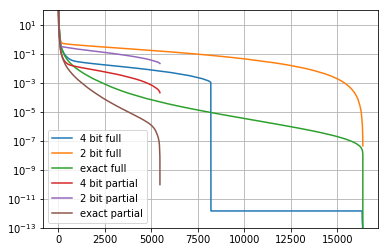

In [14]:
plt.figure()
# plt.semilogy(s_exact, label="exact")
# plt.semilogy(s_fp, label="fp")
# plt.semilogy(s_32, label="32 bit")
# plt.semilogy(s_16, label="16 bit")
# plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit full")
plt.semilogy(s_2, label="2 bit full")
plt.semilogy(s_exact, label="exact full")
plt.semilogy(s_4_small, label="4 bit partial")
plt.semilogy(s_2_small, label="2 bit partial")
plt.semilogy(s_exact_small, label="exact partial")
# plt.semilogy(s_1, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

### plot full spectrum

In [3]:
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd.npy", "rb") as f:
    s_32 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd.npy", "rb") as f:
    s_16 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd.npy", "rb") as f:
    s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd.npy", "rb") as f:
    s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact.npy", "rb") as f:
    s_exact = np.load(f)

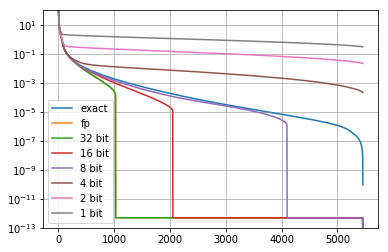

In [4]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32, label="32 bit")
plt.semilogy(s_16, label="16 bit")
plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit")
plt.semilogy(s_2, label="2 bit")
plt.semilogy(s_1, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

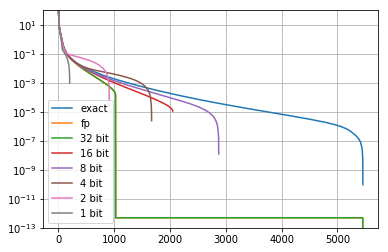

In [5]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32 - 2.0 * (1/ float(2**32 - 1) )**2, label="32 bit")
plt.semilogy(s_16 - 2.0 * (1/ float(2**16 - 1) )**2, label="16 bit")
plt.semilogy(s_8 - 2.0 * (1/ float(2**8 - 1) )**2, label="8 bit")
plt.semilogy(s_4 - 2.0 * (1/ float(2**4 - 1) )**2, label="4 bit")
plt.semilogy(s_2 - 2.0 * (1/ float(2**2 - 1) )**2, label="2 bit")
plt.semilogy(s_1 - 2.0 * (1/ float(2**1 - 1) )**2, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

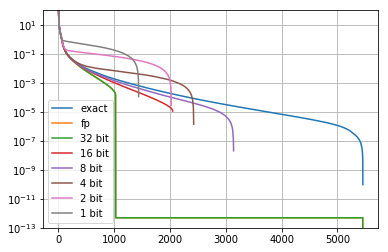

In [6]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32 - 2.0 / 3.0 * 2.0 * (1/ float(2**32 - 1) )**2, label="32 bit")
plt.semilogy(s_16 - 2.0 / 3.0 * 2.0 * (1/ float(2**16 - 1) )**2, label="16 bit")
plt.semilogy(s_8 - 2.0 / 3.0 * 2.0 * (1/ float(2**8 - 1) )**2, label="8 bit")
plt.semilogy(s_4 - 2.0 / 3.0 * 2.0 * (1/ float(2**4 - 1) )**2, label="4 bit")
plt.semilogy(s_2 - 2.0 / 3.0 * 2.0 * (1/ float(2**2 - 1) )**2, label="2 bit")
plt.semilogy(s_1 - 2.0 / 3.0 * 2.0 * (1/ float(2**1 - 1) )**2, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

### exploration on spectrum

In [37]:
def get_spectrum_test(args):
    X_train, X_test, Y_train, Y_test = load_census_data(args.data_path)
    kernel = GaussianKernel(sigma=args.sigma)
    kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)
    kernel_mat_exact_test = kernel.get_kernel_matrix(X_test, X_train)
    n_input_feat = X_train.shape[1]
    assert X_train.shape[1] == X_test.shape[1]
    if args.exact_kernel:
        print "exact kernel"
        kernel = kernel
        quantizer_train = None
        quantizer_test = None
        config_name = "exact_kernel_lambda_" + str(args.reg_lambda) + "_sigma_" + str(args.sigma)
    elif args.do_fp:
        print "full precision rff"
        kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        quantizer_train = None
        quantizer_test = None
        config_name = "fp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff)
    else:
        print "low precsion rff with nbit = ", args.n_bit
        n_quantized_rff = int(np.floor(args.n_fp_rff / float(args.n_bit) * 32.0) )
        min_val = -np.sqrt(2.0/float(n_quantized_rff) )
        max_val = np.sqrt(2.0/float(n_quantized_rff) )
        quantizer_train = Quantizer(args.n_bit, min_val, max_val, rand_seed=args.random_seed)
        if not args.test_var_reduce:
            quantizer_test = quantizer_train
        else:
            quantizer_test = None
        kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        config_name = "lp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff) + "_nbit_" + str(args.n_bit) 

    regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
    print("start to do regression!")
    # print("test quantizer", quantizer)
    regressor.fit(X_train, Y_train, quantizer=quantizer_train)
    print("finish regression!")
    
    print "test rff1 ", regressor.kernel.rff_x1
    print "test rff2 ", regressor.kernel.rff_x2
    
    
    kernel_mat = regressor.kernel_mat
    _, s, _ = np.linalg.svd(kernel_mat.cpu().numpy().astype(np.float64), full_matrices=True)
    return s, kernel_mat.cpu().numpy().astype(np.float64)

In [38]:
args = Args(n_fp_rff=1024, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1_test, kernel_1_test = get_spectrum_test(args)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!


KeyboardInterrupt: 

[ 2.  2.  2. ...,  2.  2.  2.]
[[ 2.          0.92578125  0.8515625  ...,  0.84863281  0.84277344
   0.91308594]
 [ 0.92578125  2.          0.94335938 ...,  0.88378906  0.87011719
   0.93457031]
 [ 0.8515625   0.94335938  2.         ...,  0.86230469  0.87597656
   0.91894531]]


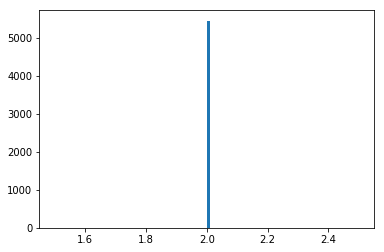

In [39]:
print np.diag(kernel_1_test)
print kernel_1_test[0:3,:]
plt.figure()
_ = plt.hist(np.diag(kernel_1_test),bins=100)
plt.show()

In [42]:
args = Args(n_fp_rff=1024, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1_test, kernel_1_test = get_spectrum_test(args)

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0073656956373598708)
('quantizer using random seed', 1)
('using regularior strength ', 0.001)
finish regression!
test rff1  
1.00000e-02 *
-1.1049  0.3683  0.3683  ...  -0.3683  0.3683  1.1049
-1.1049 -0.3683  1.1049  ...  -1.1049  1.1049  0.3683
-0.3683 -1.1049  1.1049  ...  -0.3683  1.1049  1.1049
          ...             ⋱             ...          
-1.1049 -0.3683  1.1049  ...  -1.1049  0.3683  1.1049
-1.1049 -0.3683  1.1049  ...  -1.1049  1.1049  1.1049
-0.3683 -1.1049  1.1049  ...  -0.3683  1.1049  0.3683
[torch.DoubleTensor of size 5456x16384]

test rff

[ 1.09895833  1.12087674  1.12717014 ...,  1.1265191   1.12836372
  1.12250434]
[[ 1.09895833  0.84337023  0.8390842  ...,  0.85161675  0.7464464
   0.83037652]
 [ 0.84337023  1.12087674  0.95876736 ...,  0.94986979  0.92938911
   0.91414388]
 [ 0.8390842   0.95876736  1.12717014 ...,  0.9570855   0.90725369
   0.9121365 ]]


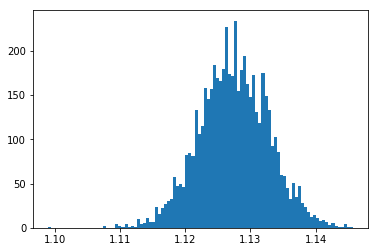

In [43]:
print np.diag(kernel_1_test)
print kernel_1_test[0:3,:]
plt.figure()
_ = plt.hist(np.diag(kernel_1_test),bins=100)
plt.show()

[  4.87422412e+03   9.92007523e+01   7.62955627e+01 ...,   6.18245899e-09
   4.54027393e-09   9.55269891e-11]


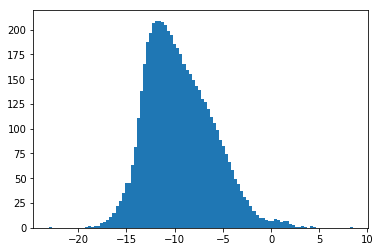

In [6]:
print s_exact
plt.figure()
_ = plt.hist(np.log(s_exact),bins=100)
plt.show()

[  4.91588923e+03   9.76161314e+01   7.45011299e+01 ...,   4.80692726e-13
   1.01362488e-13   4.13374761e-14]


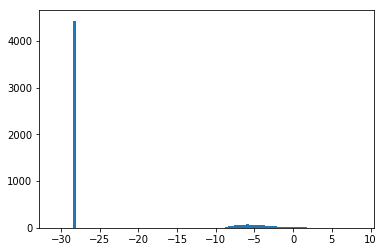

In [7]:
print s_fp
plt.figure()
_ = plt.hist(np.log(s_fp),bins=100)
plt.show()

[  4.91645370e+03   9.36678968e+01   7.49424546e+01 ...,   4.90781849e-13
   1.30537380e-13   3.44960307e-14]


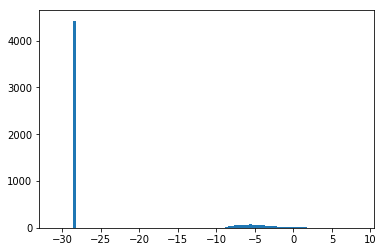

In [8]:
print s_32
plt.figure()
_ = plt.hist(np.log(s_32),bins=100)
plt.show()

[  4.92772646e+03   9.92845382e+01   7.16227742e+01 ...,   1.30972131e-13
   5.50731281e-14   5.32621153e-14]


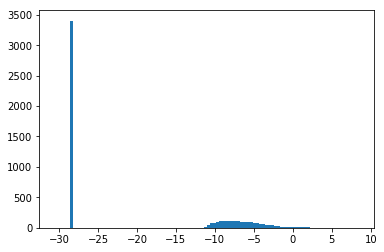

In [9]:
print s_16
plt.figure()
_ = plt.hist(np.log(s_16),bins=100)
plt.show()

[  4.79986673e+03   1.01274638e+02   8.09237702e+01 ...,   2.91166374e-14
   2.01892143e-14   6.35161380e-15]


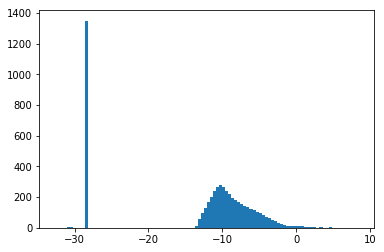

In [10]:
print s_8
plt.figure()
_ = plt.hist(np.log(s_8),bins=100)
plt.show()

[  4.85706958e+03   1.03042343e+02   7.59865365e+01 ...,   2.20834156e-04
   2.13297390e-04   2.10150551e-04]


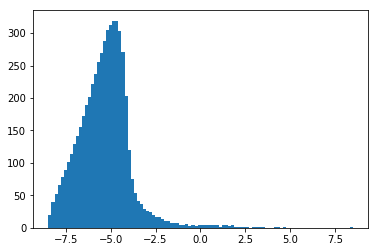

In [11]:
print s_4
plt.figure()
_ = plt.hist(np.log(s_4),bins=100)
plt.show()

[  4.87785233e+03   1.00451189e+02   8.06809640e+01 ...,   2.18074883e-02
   2.16997374e-02   2.16595938e-02]


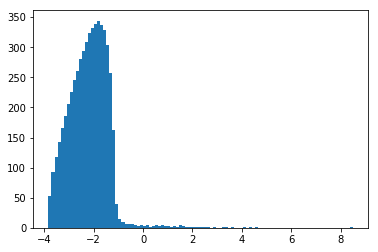

In [12]:
print s_2
plt.figure()
_ = plt.hist(np.log(s_2),bins=100)
plt.show()

[  4.87050873e+03   9.96647985e+01   8.00128565e+01 ...,   3.02800135e-01
   3.01387460e-01   3.00918557e-01]


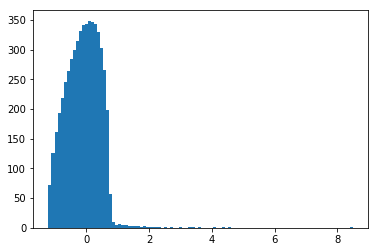

In [13]:
print s_1
plt.figure()
_ = plt.hist(np.log(s_1),bins=100)
plt.show()

# Below are old cold

(array([ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  7.01975496e-03,   1.65006816e+00,   3.29311657e+00,
          4.93616497e+00,   6.57921338e+00,   8.22226178e+00,
          9.86531019e+00,   1.15083586e+01,   1.31514070e+01,
          1.47944554e+01,   1.64375038e+01]),
 <a list of 10 Patch objects>)

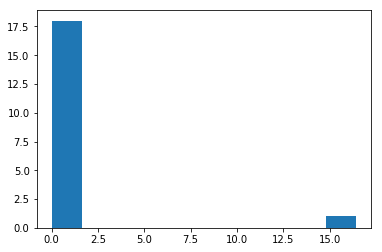

In [56]:
plt.hist(s)